In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [252]:
import re # We clean text using regex
import csv # To read the csv
from collections import defaultdict # For accumlating values
from nltk.corpus import stopwords # To remove stopwords
from gensim import corpora # To create corpus and dictionary for the LDA model
from gensim.models import LdaModel # To use the LDA model
import pyLDAvis.gensim # To visualise LDA model effectively
import gensim

In [253]:
import spacy
# !python -m spacy download en

In [254]:
import warnings
warnings.filterwarnings(action='ignore')

In [255]:
import nltk
# nltk.download('stopwords')

In [256]:
data=pd.read_csv('amazon_reviews_data.csv')
data

,author,title,date,content,rating
0,Christine,impossible to understand intercom messages and...,31-Jan-19,The echo dot 2nd generation worked perfectly a...,1
1,Amazon Customer,Not that smart,15-Mar-19,I thought it would be smarter than it is. I h...,3
2,Amazon Customer,nowhere near as nice as the tower,02-May-19,the volume is very low in comparison to the to...,2
3,Jammy Dodger,Very disappointing compared to previous models,04-Dec-18,"I have 2 original echo dots, a first gen Echo ...",2
4,Richard,Prepare to be frustrated - inconsistant functi...,27-Apr-19,I purchased two 3rd generation dots primarily ...,2
...,...,...,...,...,...
15456,j.r.fellabaum,Take Alexa With You via your phone as a wifi h...,19-Mar-19,See my other post....using this one in my car ...,5
15457,Amazon Customer,Make all my purchases with Amazon,30-Mar-19,What did I like about this product? Love love ...,5
15458,candace j. cavanaugh,Fun!,03-May-19,I bought the echo on a whim and I am so glad I...,5
15459,Kaitlin Reitz,Great product,05-Apr-19,Got this free with our Ring doorbell. We alrea...,5


In [257]:
data['rating'].describe()

count    15461.000000
mean         4.176121
std          1.222562
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [258]:
data['author'].value_counts()

Amazon Customer    1274
Kindle Customer      91
Chris                24
John                 24
Michael              23
                   ... 
Judy C.               1
Lizzy Busy            1
iamforce              1
ANN H.                1
Patrice Harzke        1
Name: author, Length: 12604, dtype: int64

### Gensim LDA


In [259]:
data=data.replace(r'[^\w\s]','',regex=True)

In [260]:
stopwords = set(stopwords.words('english'))

In [261]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [262]:
token_word=list(sent_to_words(data['content']))

In [263]:
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [264]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(token_word, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[token_word], threshold=100)
 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
 
# See trigram example
print(trigram_mod[bigram_mod[token_word[0]]])

['the', 'echo', 'dot', 'nd', 'generation', 'worked', 'perfectly', 'as', 'an', 'intercom', 'using', 'the', 'drop', 'in', 'command', 'the', 'rd', 'generation', 'echo', 'dot', 'has', 'the', 'audio', 'going', 'in', 'and', 'out', 'mid', 'sentence', 'making', 'it', 'impossible', 'to', 'understand', 'the', 'echo', 'as', 'an', 'intercom', 'as', 'time', 'went', 'on', 'the', 'rd', 'generation', 'speaker', 'did', 'not', 'get', 'any', 'clearer', 'swapping', 'out', 'one', 'rd', 'generation', 'for', 'another', 'did', 'not', 'solve', 'the', 'problems', 'with', 'clarity', 'the', 'rd', 'generation', 'has', 'problems', 'when', 'two', 'people', 'are', 'talking', 'more', 'than', 'the', 'nd', 'generation', 'also', 'music', 'playing', 'on', 'either', 'side', 'of', 'the', 'connection', 'will', 'cause', 'problems', 'with', 'message', 'clarity', 'on', 'the', 'rd', 'generation', 'echo', 'dot', 'the', 'rd', 'generation', 'device', 'rather', 'than', 'learning', 'your', 'voice', 'and', 'distinguishing', 'when', 'y

In [265]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
 
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [266]:
import en_core_web_sm


# Remove Stop Words
data_words_nostops = remove_stopwords(token_word)
 
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
 
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = en_core_web_sm.load()
 
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
print(data_lemmatized[:1])

[['generation', 'work', 'perfectly', 'intercom', 'use', 'dot', 'audio', 'go', 'mid', 'sentence', 'make', 'impossible', 'understand', 'go', 'generation', 'clear', 'swap', 'generation', 'solve', 'problem', 'clarity', 'generation', 'problem', 'people', 'talk', 'generation', 'also', 'music', 'play', 'side', 'connection', 'cause', 'problem', 'message', 'clarity', 'generation', 'dot', 'rd', 'generation', 'device', 'rather', 'learn', 'voice', 'distinguishing', 'talk', 'subtracting', 'interfere', 'message', 'clarity', 'dot', 'much', 'music', 'people', 'talk', 'time', 'cause', 'speaker', 'garble', 'message', 'generation', 'generation', 'rely', 'training', 'user', 'turn', 'music', 'wait', 'patiently', 'person', 'end', 'talk', 'customer', 'expect', 'artificial', 'intelligent', 'device', 'service', 'responsive', 'polite', 'make', 'overture', 'correct', 'problem', 'however', 'promise', 'call', 'back', 'make', 'even', 'schedule', 'give', 'call', 'number', 'email', 'respond', 'add', 'additional', 'co

In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(token_word)

In [28]:
data_words_nostops

[['echo',
  'dot',
  'nd',
  'generation',
  'worked',
  'perfectly',
  'intercom',
  'using',
  'drop',
  'command',
  'rd',
  'generation',
  'echo',
  'dot',
  'audio',
  'going',
  'mid',
  'sentence',
  'making',
  'impossible',
  'understand',
  'echo',
  'intercom',
  'time',
  'went',
  'rd',
  'generation',
  'speaker',
  'get',
  'clearer',
  'swapping',
  'one',
  'rd',
  'generation',
  'another',
  'solve',
  'problems',
  'clarity',
  'rd',
  'generation',
  'problems',
  'two',
  'people',
  'talking',
  'nd',
  'generation',
  'also',
  'music',
  'playing',
  'either',
  'side',
  'connection',
  'cause',
  'problems',
  'message',
  'clarity',
  'rd',
  'generation',
  'echo',
  'dot',
  'rd',
  'generation',
  'device',
  'rather',
  'learning',
  'voice',
  'distinguishing',
  'talk',
  'subtracting',
  'background',
  'noise',
  'background',
  'noise',
  'interfere',
  'message',
  'clarity',
  'nd',
  'generation',
  'echo',
  'dot',
  'much',
  'background',
  '

In [267]:
# Create Dictionary

id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 5), (10, 2), (11, 1), (12, 3), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 2), (26, 2), (27, 1), (28, 3), (29, 2), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 2), (37, 3), (38, 1), (39, 1), (40, 18), (41, 2), (42, 3), (43, 1), (44, 1), (45, 10), (46, 1), (47, 2), (48, 8), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 3), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 4), (62, 1), (63, 11), (64, 2), (65, 2), (66, 3), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 3), (73, 1), (74, 1), (75, 4), (76, 3), (77, 1), (78, 2), (79, 1), (80, 2), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 1), (91, 1), (92, 2), (93, 3), (94, 1), (95, 2), (96, 3), (97, 1), (98, 2), (99, 1), (100, 1), (101, 1), (102, 2), (103, 1), (104, 1), (105, 1), (106, 2), (107, 2), (108, 2), (109, 1), (110,

In [268]:
id2word[0]

'ability'

In [269]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('actual', 1),
  ('add', 1),
  ('additional', 2),
  ('address', 1),
  ('advertise', 1),
  ('alexa', 1),
  ('also', 1),
  ('announcement', 2),
  ('answer', 5),
  ('appear', 2),
  ('application', 1),
  ('artificial', 3),
  ('ass', 2),
  ('assistant', 2),
  ('audio', 1),
  ('avoidable', 1),
  ('back', 1),
  ('bargain', 1),
  ('base', 1),
  ('become', 1),
  ('bedroom', 1),
  ('bit', 1),
  ('buy', 1),
  ('call', 2),
  ('can', 2),
  ('cause', 2),
  ('channel', 1),
  ('clarity', 3),
  ('clear', 2),
  ('compatible', 1),
  ('computer', 1),
  ('concern', 2),
  ('concerned', 1),
  ('connection', 1),
  ('consider', 1),
  ('correct', 2),
  ('customer', 3),
  ('deal', 1),
  ('description', 1),
  ('device', 18),
  ('digital', 2),
  ('disconnect', 3),
  ('discount', 1),
  ('distinguishing', 1),
  ('dot', 10),
  ('drop', 1),
  ('dumb', 2),
  ('echo', 8),
  ('ed', 1),
  ('email', 1),
  ('encounter', 1),
  ('end', 1),
  ('enough', 2),
  ('equipment', 1),
  ('even', 3),
  ('expect', 3)

In [270]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=6,
random_state=123,
update_every=1,
chunksize=100,
passes=10,
alpha='auto',
per_word_topics=True)

In [271]:
topics = lda_model.show_topics()
for topic in topics:
    print(topic)

(0, '0.028*"whole" + 0.028*"soon" + 0.026*"hook" + 0.024*"pay" + 0.021*"entertainment" + 0.018*"extra" + 0.017*"stream" + 0.017*"med" + 0.016*"year_old" + 0.014*"leg"')
(1, '0.093*"turn" + 0.087*"light" + 0.078*"question" + 0.061*"perfect" + 0.044*"helpful" + 0.036*"answer" + 0.019*"name" + 0.019*"lamp" + 0.013*"exactly" + 0.013*"everyday"')
(2, '0.046*"work" + 0.037*"use" + 0.036*"easy" + 0.032*"product" + 0.027*"set" + 0.025*"device" + 0.024*"buy" + 0.017*"would" + 0.016*"home" + 0.015*"be"')
(3, '0.082*"sound" + 0.066*"dot" + 0.048*"well" + 0.047*"echo" + 0.046*"good" + 0.035*"much" + 0.028*"quality" + 0.028*"speaker" + 0.018*"great" + 0.015*"room"')
(4, '0.083*"enjoy" + 0.038*"absolutely" + 0.028*"drop" + 0.024*"life" + 0.017*"bathroom" + 0.016*"integrate" + 0.015*"listening" + 0.015*"fantastic" + 0.015*"fact" + 0.015*"couple"')
(5, '0.105*"love" + 0.062*"great" + 0.062*"music" + 0.044*"alexa" + 0.032*"play" + 0.029*"use" + 0.023*"get" + 0.021*"thing" + 0.020*"listen" + 0.019*"ask"

In [272]:
lda_model.print_topic(0)

'0.028*"whole" + 0.028*"soon" + 0.026*"hook" + 0.024*"pay" + 0.021*"entertainment" + 0.018*"extra" + 0.017*"stream" + 0.017*"med" + 0.016*"year_old" + 0.014*"leg"'

In [274]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.173813  0.302121       1        1  32.199098
5     -0.264521  0.010326       2        1  29.697559
3     -0.166568 -0.321166       3        1  26.945553
4      0.207829  0.001889       4        1   4.469720
1      0.202079  0.003309       5        1   3.755530
0      0.194994  0.003521       6        1   2.932540, topic_info=            Term         Freq        Total Category  logprob  loglift
376         love  8095.000000  8095.000000  Default  30.0000  30.0000
292        sound  5732.000000  5732.000000  Default  29.0000  29.0000
45           dot  4584.000000  4584.000000  Default  28.0000  28.0000
96         music  4767.000000  4767.000000  Default  27.0000  27.0000
192         well  3377.000000  3377.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1083      choice    58.179031    59.608049   Topic6  -4.8711   3.5050
3042   skeptical    57.355605    58.794039   Topic6  -4.8854   3.5045
3966  unexpected    58.367011    59.895350   Topic6  -4.8679   3.5035
1101       movie    54.646323    56.078056   Topic6  -4.9338   3.5034
247          car    54.046535    55.475529   Topic6  -4.9448   3.5032

[233 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1001      4  0.997201  absolutely
238       6  0.982823     account
2         1  0.997894         add
822       3  0.996115    addition
5         6  0.986189   advertise
...     ...       ...         ...
270       6  0.994942       whole
173       1  0.999556        work
193       1  0.998972       would
2295      6  0.990805    year_old
215       4  0.994218         yet

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 4, 5, 2, 1])

In [275]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
 
# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.9475975892267785

Coherence Score:  0.4820252816379568


In [291]:
word_dict = {};
for i in range(6):
    words = lda_model.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,whole,turn,work,sound,enjoy,love
1,soon,light,use,dot,absolutely,great
2,hook,question,easy,well,drop,music
3,pay,perfect,product,echo,life,alexa
4,entertainment,helpful,set,good,bathroom,play
5,extra,answer,device,much,integrate,use
6,stream,name,buy,quality,listening,get
7,med,lamp,would,speaker,fantastic,thing
8,year_old,exactly,home,great,fact,listen
9,leg,everyday,be,room,couple,ask


### Scikit-learn LDA

In [234]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import time
vectorizer = TfidfVectorizer(stop_words="english",
                            use_idf=True,
                            ngram_range=(1,1), 
                            min_df = 0.05,     
                            max_df = 0.5)     

t0=time.time()

tfidf = vectorizer.fit_transform(data['content'])

print("완료시간 : %0.3f초" % (time.time() - t0))

완료시간 : 0.823초


In [236]:
vectorizer = CountVectorizer(stop_words="english",
                            ngram_range=(1,1), 
                            min_df = 0.05,     
                            max_df = 0.5)      

t0=time.time()

tfidf = vectorizer.fit_transform(data['content'])

print("완료시간 : %0.3f초" % (time.time() - t0))

완료시간 : 0.804초


<AxesSubplot:xlabel='rank', ylabel='term'>

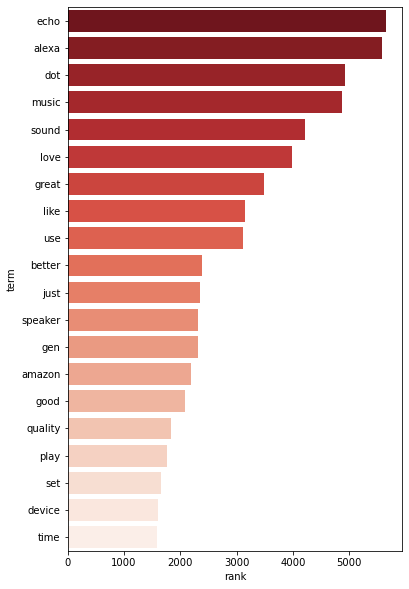

In [237]:

def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0) # 문서마다 단어의 tfidf 합산
    data = []
    for col, term in enumerate(terms): 
        data.append( (term, sums[0,col])) # 단어의 tfidf 값 매핑하여 리스트에 추가
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank',ascending=False) 
    # tfidf 내림차순으로 정렬하여 데이터프레임 생성  
    return ranked 

ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)

fix, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette="Reds_r", ax=ax)

In [229]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics= 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)

topics= lda.fit_transform(tfidf)

top_n_words = 6
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] =[vectorizer.get_feature_names()[i] 
                    for i in t.argsort()[:-top_n_words -1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words-1:-1]]
t_words    

{0: ['like', 'alexa', 'work', 'don', 'just', 'time'],
 1: ['easy', 'use', 'set', 'ask', 'things', 'weather'],
 2: ['love', 'music', 'play', 'alexa', 'echo', 'bought'],
 3: ['product', 'echo', 'dot', 'amazon', 'really', 'does'],
 4: ['sound', 'better', 'gen', 'quality', 'generation', 'dot'],
 5: ['great', 'works', 'good', 'home', 'smart', 'device']}

In [238]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics= 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)

topics= lda.fit_transform(tfidf)

top_n_words = 6
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] =[vectorizer.get_feature_names()[i] 
                    for i in t.argsort()[:-top_n_words -1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words-1:-1]]
t_words    

{0: ['gen', '3rd', 'generation', '2nd', 'dot', 'better'],
 1: ['use', 'like', 'set', 'music', 'easy', 'alexa'],
 2: ['love', 'music', 'alexa', 'play', 'room', 'house'],
 3: ['echo', 'dot', 'amazon', 'new', 'music', 'like'],
 4: ['sound', 'quality', 'better', 'speaker', 'good', 'great'],
 5: ['alexa', 'great', 'home', 'works', 'smart', 'good']}

KeyError: 6

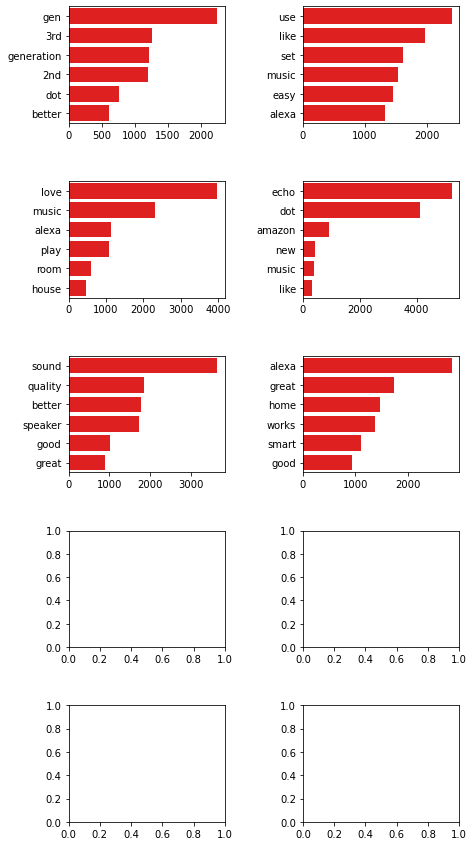

In [248]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(wspace = 0.5, hspace=0.5)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c],
                   color="red",ax=ax[row][col])
        c+=1
plt.show()

In [288]:
# 문서를 삽입할 pipeline을 형성하고, 주제 적절성을 추출
from sklearn.pipeline import Pipeline
pipe = Pipeline([('tfidf', vectorizer),
                ('lda',lda)])

document_id =2
t = pipe.transform([data['content'].iloc[document_id]])
print('문서 #{}에 대한 토픽 배분: \n'.format(document_id),t)
print('\n문서 #{}에 대한 주제 관련성 \n'.format(document_id),t.max(), )
print('\n자막:\n',data['content'].iloc[document_id][:500],"...")


문서 #2에 대한 토픽 배분: 
 [[0.05570482 0.33600073 0.44087224 0.05592788 0.05564352 0.05585082]]

문서 #2에 대한 주제 관련성 
 0.4408722411689197

자막:
 the volume is very low in comparison to the tower version even when turned all the way up  I bought this to use as an alarm clock  and have found it to be useless ...


In [242]:
col=['Topic_'+str(i) for i in range(6)]

In [243]:
t= pipe.transform(data['content'])
t=pd.DataFrame(t, columns=col)
t.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,0.435724,0.001894,0.001885,0.354724,0.001887,0.203885
1,0.023907,0.023947,0.333300,0.023835,0.244737,0.350274
2,0.055705,0.336001,0.440872,0.055928,0.055644,0.055851
3,0.610996,0.009321,0.009297,0.351759,0.009268,0.009359
4,0.179878,0.012004,0.772311,0.011922,0.011919,0.011966


In [244]:
content_len=[]
for i in range(len(data['content'])):
    content_len.append(len(data['content'][i]))

In [224]:
content_len

[4503,
 357,
 162,
 554,
 709,
 52,
 222,
 370,
 224,
 86,
 3,
 165,
 151,
 182,
 59,
 358,
 238,
 411,
 466,
 132,
 158,
 445,
 511,
 208,
 180,
 1190,
 44,
 78,
 62,
 94,
 74,
 61,
 482,
 390,
 19,
 985,
 77,
 187,
 138,
 333,
 36,
 2866,
 122,
 287,
 275,
 515,
 238,
 191,
 237,
 76,
 443,
 345,
 62,
 257,
 495,
 596,
 901,
 267,
 92,
 102,
 295,
 190,
 61,
 69,
 821,
 934,
 135,
 146,
 246,
 82,
 111,
 2117,
 1313,
 131,
 649,
 160,
 386,
 49,
 116,
 111,
 149,
 249,
 99,
 305,
 55,
 168,
 37,
 894,
 115,
 131,
 184,
 229,
 139,
 1745,
 881,
 77,
 984,
 119,
 40,
 761,
 86,
 435,
 270,
 64,
 95,
 654,
 432,
 216,
 274,
 33,
 451,
 261,
 311,
 376,
 282,
 155,
 418,
 220,
 83,
 507,
 459,
 46,
 714,
 825,
 1300,
 2258,
 43,
 162,
 92,
 469,
 87,
 151,
 1212,
 180,
 35,
 94,
 38,
 99,
 94,
 241,
 54,
 223,
 181,
 112,
 44,
 1007,
 72,
 475,
 322,
 665,
 384,
 8,
 399,
 173,
 27,
 86,
 230,
 14,
 170,
 237,
 182,
 327,
 40,
 165,
 212,
 1094,
 590,
 69,
 313,
 96,
 80,
 616,
 208,
 67

In [245]:
topic_data=pd.concat([t,data['rating']],axis=1)

In [246]:
topic_data.loc[:,'content_len']=content_len
topic_data

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,rating,content_len
0,0.435724,0.001894,0.001885,0.354724,0.001887,0.203885,1,4503
1,0.023907,0.023947,0.333300,0.023835,0.244737,0.350274,3,357
2,0.055705,0.336001,0.440872,0.055928,0.055644,0.055851,2,162
3,0.610996,0.009321,0.009297,0.351759,0.009268,0.009359,2,554
4,0.179878,0.012004,0.772311,0.011922,0.011919,0.011966,2,709
...,...,...,...,...,...,...,...,...
15456,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,5,55
15457,0.027936,0.294625,0.370971,0.250592,0.027780,0.028095,5,59
15458,0.027897,0.027918,0.028115,0.435370,0.027801,0.452898,5,221
15459,0.033505,0.033605,0.033942,0.033494,0.033435,0.832019,5,151


In [250]:
topic_data=topic_data.drop(['Topic_0'],axis=1)

In [251]:
topic_data.to_csv('topic_data.csv',index=False)